Use a subset of data to run a small registration example.

In [1]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
import emlddmm
import json
import os
from datetime import datetime

# for debugging only
import imp
imp.reload(emlddmm)

<module 'emlddmm' from 'c:\\Users\\BGAdmin\\emlddmm\\emlddmm.py'>

In [2]:
# todo list in this cell
# explicitly write out forward and inverse transforms instead of velocity field
# specifics for 3D to 2D mapping
# apply transforms to new data from command line
# different data types: either preprocess data and convert format, or modify code to support another data type
# reading and writing in other data types: especially nifty nii, I would rely on nibabel to do this

In [3]:
# # maybe I want to use the exvivo, not the atlas. that can be a version 2.
# atlas_name = 'Allen_Atlas_vtk/ara_nissl_100.vtk'
# label_name = 'Allen_Atlas_vtk/annotation_100.vtk'
# target_name = 'MD787_small_nissl'
# config_file = 'config787small.json'
# output_dir = '787_small_test_outputs/'


In [19]:
# maybe I want to use the exvivo, not the atlas. that can be a version 2.
atlas_name = 'Allen_Atlas_vtk/ara_nissl_50.vtk'
label_name = 'Allen_Atlas_vtk/annotation_50.vtk'
target_name = 'C:\\Users\\BGAdmin\\data\\MD816\\MD816_STIF'
config_file = 'config787small.json'
time = datetime.now().strftime("%Y_%m_%d-%I_%M_%S")
output_dir = '787_small_test_outputs_'+time

In [5]:
# note about downsampling
# atlas is size 50x50x50
# data is size 14.74*3x14.72*3x200 (i.e. 10 micron, downsampled by a factor of 20)

In [6]:
with open(config_file) as f:
    config = json.load(f)
# I'm getting this for initial downsampling for preprocessing
downIs = config['downI']
downJs = config['downJ']

Found extension .vtk
[50. 50. 50.]


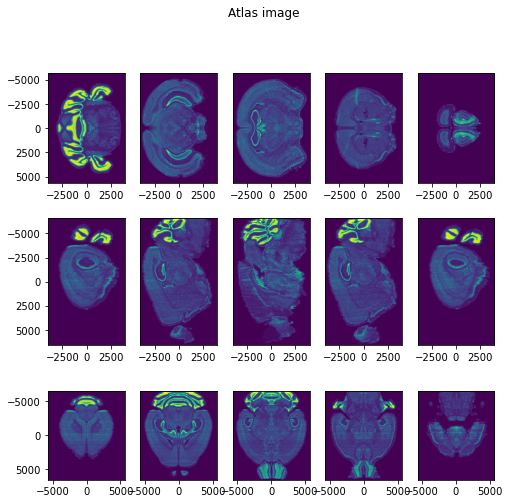

In [7]:
plt.rcParams["figure.figsize"] = (8,8)
# atlas
xI,I,title,names = emlddmm.read_data(atlas_name)
I = I.astype(float)
# normalize
I /= np.mean(np.abs(I))
dI = np.array([x[1]-x[0] for x in xI])
print(dI)
fig = emlddmm.draw(I,xI)
fig[0].suptitle('Atlas image')
fig[0].canvas.draw()

In [8]:
# initial downsampling so there isn't so much on the gpu
mindownI = np.min(np.array(downIs),0)
xI,I = emlddmm.downsample_image_domain(xI,I,mindownI)
downIs = [ list((np.array(d)/mindownI).astype(int)) for d in downIs]
dI = [x[1]-x[0] for x in xI]
print(dI)
nI = np.array(I.shape,dtype=int)
# update our config variable
config['downI'] = downIs

[50.0, 50.0, 50.0]


In [9]:
# destination = 'C:\\Users\\BGAdmin\\data\\MD816\\outliers'
# file_list = os.listdir(target_name)
# height = []
# width = []
# for j in file_list:
#     if '.tif' in j:
#         J = plt.imread(os.path.join(target_name,j))
#         height.append(J.shape[0])
#         width.append(J.shape[1])
#         ratio = J.shape[1]/J.shape[0]
#         shape_sum = J.shape[1]+J.shape[0]
#         if shape_sum >= 2308:
#             print('size > 99th:\n',j)
#             fname, ext = os.path.splitext(j)
#             plt.imsave(fname=os.path.join(destination, 'large', fname+'.png'), arr=J, format='png')
#         if ratio >= 1.66750:
#             print('ratio > 99th:\n', j)
#             plt.imsave(fname=os.path.join(destination, 'wide', fname+'.png'), arr=J, format='png')
#         if ratio <= 0.75074:
#             print('ratio < 1st:\n', j)
#             plt.imsave(fname=os.path.join(destination, 'tall', fname+'.png'), arr=J, format='png')


In [10]:
# size_ratio = np.array(width)/np.array(height)
# size_sum = np.array(width) + np.array(height)
# ratio_99 = np.percentile(size_ratio, 99)
# ratio_1 = np.percentile(size_ratio, 1)
# sum_99 = np.percentile(size_sum, 99)
# width_99 = np.percentile(width,99)
# height_99 = np.percentile(height,99)
# print('width 99th percentile: ', width_99)
# print('height 99th percentile: ', height_99)
# print('sum 99th percentile: ', sum_99)
# print('ratio 98% interval: ', ratio_1, ratio_99)

In [11]:
# fig, axs = plt.subplots(3)
# fig.set_size_inches(10,10)
# size_ratio = np.array(width)/np.array(height)
# axs[0].hist(size_ratio, bins=50)
# axs[0].set_title('Size Ratio (width/height)')
# axs[1].hist(height, bins=50)
# axs[1].set_title('Height')
# axs[2].hist(width, bins=50)
# axs[2].set_title('Width')
# plt.savefig(os.path.join(destination, 'histograms.png'))
# plt.show()

initial downsampling factor:  [1 5 5]
Found extension 
loading target images
padding and assembling into 3D volume
[10.  73.6 73.6]


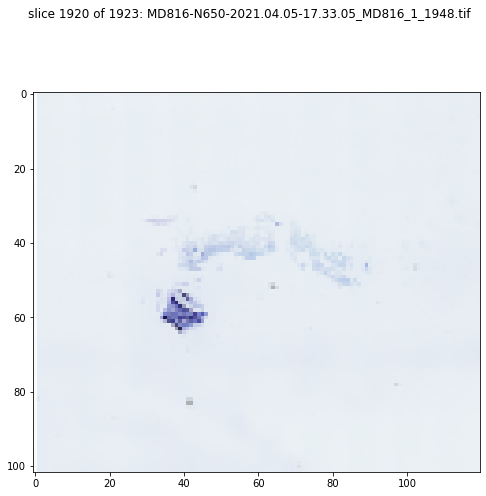

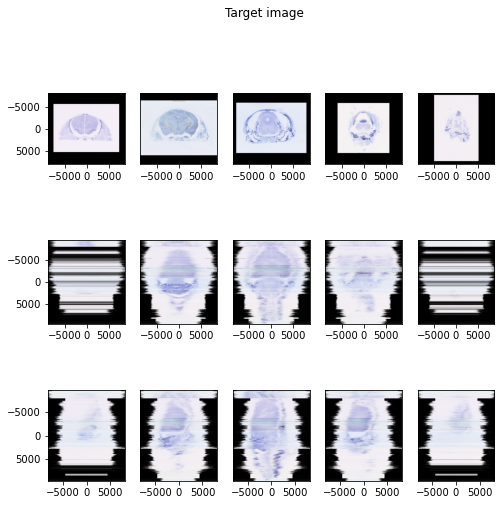

In [12]:
# target
imp.reload(emlddmm)
mindownJ = np.min(np.array(downJs),0)
print('initial downsampling factor: ', mindownJ)
xJ,J,title,names = emlddmm.read_data(target_name, down= list(mindownJ))
if 'mask' in names:
    maskind = names.index('mask')
    W0 = J[maskind]
    J = J[np.arange(J.shape[0])!=maskind]    
dJ = np.array([x[1]-x[0] for x in xJ])
print(dJ)
J = J.astype(float)
fig = emlddmm.draw(J,xJ, vmin=0, vmax=1)
fig[0].suptitle('Target image')
fig[0].canvas.draw()

In [13]:
print(W0.shape)
print(J.shape)
print([i.shape for i in xJ])

(1923, 223, 239)
(3, 1923, 223, 239)
[(1923,), (223,), (239,)]


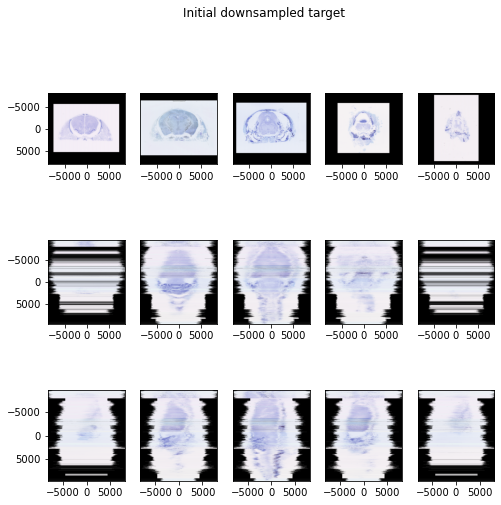

In [14]:
# initial downsampling so there isn't so much on the gpu
# mindownJ = np.min(np.array(downJs),0)
# xJ,J = emlddmm.downsample_image_domain(xJ,J,mindownJ)
# W0 = emlddmm.downsample(W0,mindownJ)
downJs = [ list((np.array(d)/mindownJ).astype(int)) for d in downJs]
dJ = [x[1]-x[0] for x in xJ]
nJ = np.array(J.shape,dtype=int)
# update our config variable
config['downJ'] = downJs
fig = emlddmm.draw(J,xJ)
fig[0].suptitle('Initial downsampled target')
fig[0].canvas.draw()

In [15]:
print(W0.shape)
print(J.shape)
print([i.shape for i in xJ])
print(dJ)
print(nJ)

(1923, 223, 239)
(3, 1923, 223, 239)
[(1923,), (223,), (239,)]
[10.0, 73.60000000000036, 73.60000000000036]
[   3 1923  223  239]


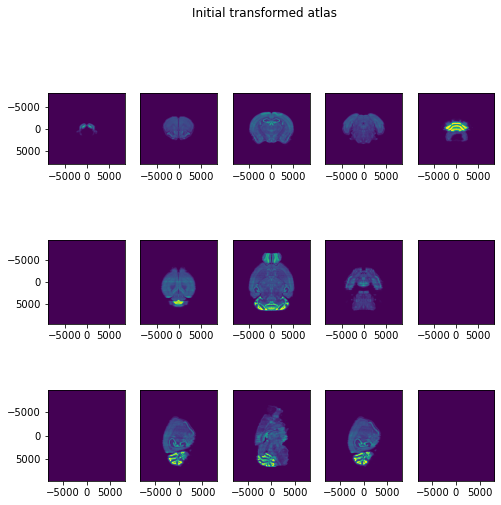

In [16]:
imp.reload(emlddmm)
# visualize initial affine
if 'A' in config:
    A = np.array(config['A']).astype(float)
else:
    A = np.eye(4)

# this affine matrix should be 4x4, but it may be 1x4x4
if A.ndim > 2:
    A = A[0]    

Ai = np.linalg.inv(A)
XJ = np.stack(np.meshgrid(*xJ,indexing='ij'),-1)
Xs = (Ai[:3,:3]@XJ[...,None])[...,0] + Ai[:3,-1]
out = emlddmm.interp(xI,I,Xs.transpose((3,0,1,2)))
fig = emlddmm.draw(out,xJ)
fig[0].suptitle('Initial transformed atlas')
fig[0].canvas.draw()

In [22]:
del config['device']

In [23]:
# list the config options
for k in config:
    print(f'{k} : {config[k]}')

n_iter : [1000, 500]
downI : [[2, 2, 2], [1, 1, 1]]
downJ : [[1, 2, 2], [1, 1, 1]]
priors : [[0.9, 0.05, 0.05]]
sigmaM : [0.1]
sigmaB : [0.2]
sigmaA : [0.5]
sigmaR : [1000.0]
ev : [0]
eA : [0, 0]
eA2d : [200.0, 50.0]
slice_matching : [1]
update_muA : [0]
update_muB : [0]
muA : [[0.1, 0.1, 0.1]]
muB : [[0.9, 0.9, 0.9]]
update_sigmaM : [0]
update_sigmaA : [0]
update_sigmaB : [0]
order : [3]
n_draw : [50]
n_e_step : [3]
slice_matching_start : [300, 0]
v_start : [10000, 0, 0]
A : [[[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]]


In [24]:
# device = 'cuda:0'
device = 'cpu'
output = emlddmm.emlddmm_multiscale(I=I,xI=[xI],J=J,xJ=[xJ],W0=W0,device=device,**config)

Found 2 scales
dv tensor([150., 150., 150.])
a scale is 300.0


C:\Users\BGAdmin\anaconda3\lib\site-packages\torch\autograd\__init__.py:147: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ..\aten\src\ATen\native\Copy.cpp:240.)
  Variable._execution_engine.run_backward(
c:\Users\BGAdmin\emlddmm\emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 0
Finished iteration 10
Finished iteration 20
Finished iteration 30
Finished iteration 40


c:\Users\BGAdmin\emlddmm\emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 50
Finished iteration 60
Finished iteration 70
Finished iteration 80
Finished iteration 90


c:\Users\BGAdmin\emlddmm\emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 100
Finished iteration 110
Finished iteration 120
Finished iteration 130
Finished iteration 140


c:\Users\BGAdmin\emlddmm\emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 150
Finished iteration 160
Finished iteration 170
Finished iteration 180
Finished iteration 190


c:\Users\BGAdmin\emlddmm\emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 200
Finished iteration 210
Finished iteration 220
Finished iteration 230
Finished iteration 240


c:\Users\BGAdmin\emlddmm\emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 250
Finished iteration 260
Finished iteration 270
Finished iteration 280
Finished iteration 290


c:\Users\BGAdmin\emlddmm\emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 300
Finished iteration 310
Finished iteration 320
Finished iteration 330
Finished iteration 340


c:\Users\BGAdmin\emlddmm\emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 350
Finished iteration 360
Finished iteration 370
Finished iteration 380
Finished iteration 390


c:\Users\BGAdmin\emlddmm\emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 400
Finished iteration 410
Finished iteration 420
Finished iteration 430
Finished iteration 440


c:\Users\BGAdmin\emlddmm\emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 450
Finished iteration 460
Finished iteration 470
Finished iteration 480
Finished iteration 490


c:\Users\BGAdmin\emlddmm\emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 500
Finished iteration 510


In [ ]:
emlddmm.write_transform_outputs(output_dir,output[-1])

In [ ]:
# get labels
imp.reload(emlddmm)
xS,S,title,names = emlddmm.read_data(label_name,endian='l')
emlddmm.write_qc_outputs(output_dir,output[-1],xI,I,xJ,J,xS=xS,S=S.astype(float))

In [ ]:
# save config used to output
with open(config_file) as f:
    config = json.load(f)
with open(os.path.join(output_dir, 'config.json'), 'w') as f:
    json.dump(config, f)